In [104]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt 
import statsmodels.api as sm
from itertools import product
from tqdm import tqdm_notebook
%matplotlib inline

In [105]:
ads = pd.read_csv("ads.csv", index_col=['Time'], parse_dates=['Time'])
curr = pd.read_csv("currency.csv", index_col=['Time'], parse_dates=['Time'])    #ads watched/day and in-game curr spent/day

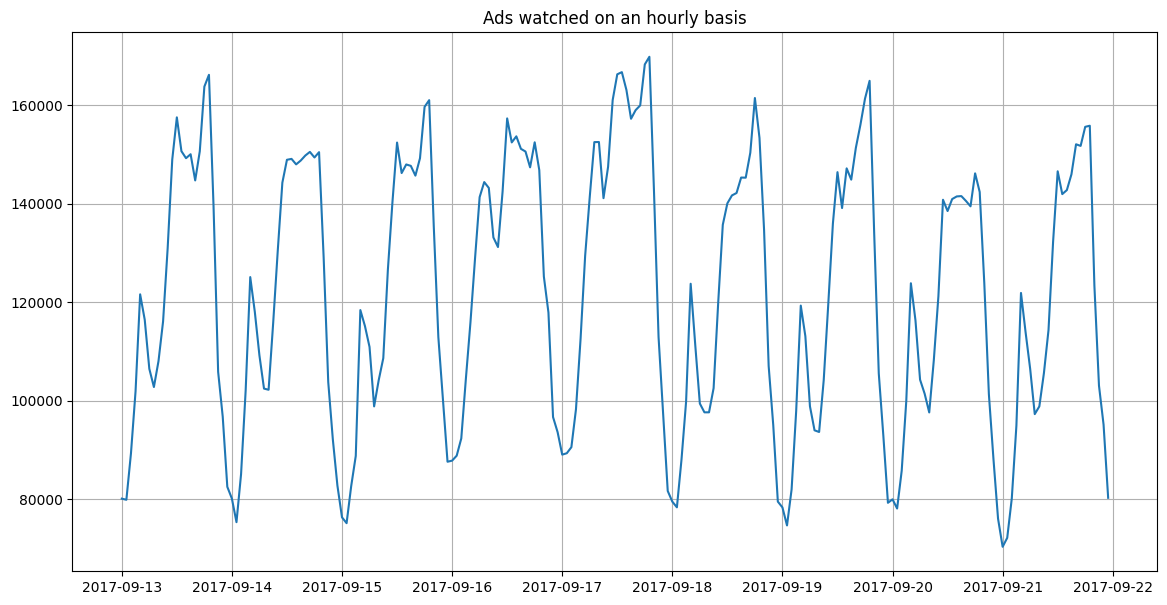

In [106]:
plt.figure(figsize=(14, 7))
plt.plot(ads.Ads)
plt.title("Ads watched on an hourly basis")
plt.grid(True)
plt.show()

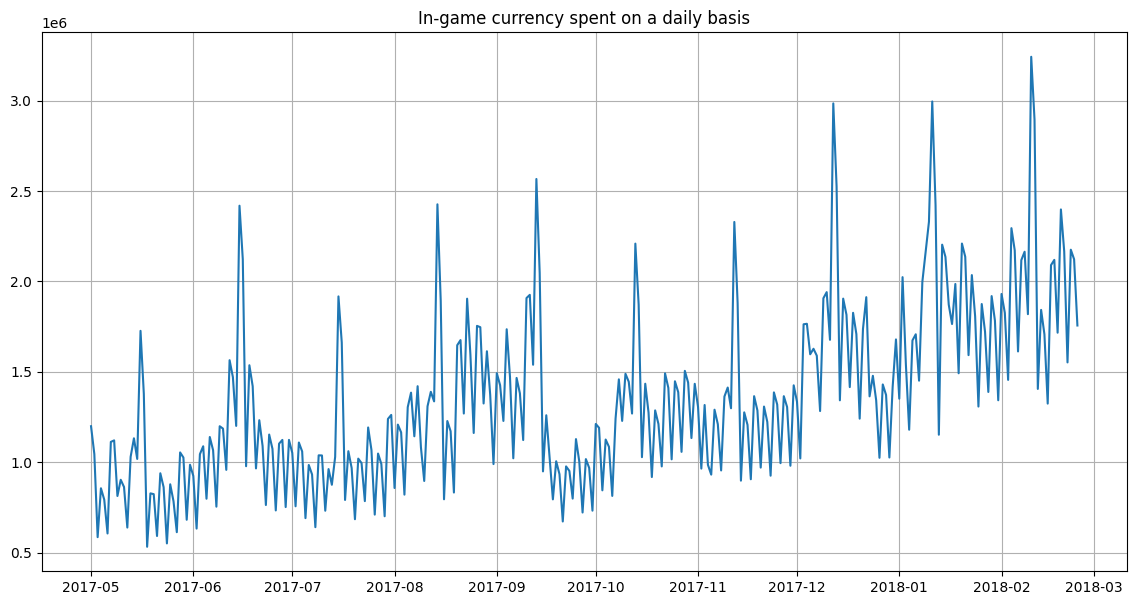

In [107]:
plt.figure(figsize=(14, 7))
plt.plot(curr.GEMS_GEMS_SPENT)
plt.title("In-game currency spent on a daily basis")
plt.grid(True)
plt.show()

## Some commonly used metricss:
1. R-squared: - coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model),  (−∞,1]
R2=1−(SSres/SStot)

2. Mean absolute err: - this is an interpretable metric because it has the same unit of measurment as the initial series,  [0,+∞)
MAE=(∑i=1n|yi−y^i|)/n   -y cap and not y to the power of

3. Median Absolute error: - again, an interpretable metric that is particularly interesting because it is robust to outliers,  [0,+∞)
MedAE=median(|y1−y^1|,...,|yn−y^n|) -y cap and not y to the power of

4. Mean Squared Error: - the most commonly used metric that gives a higher penalty to large errors and vice versa,  [0,+∞)
MSE=1/n*∑i=1n(yi−y^i)^2   -y cap and not y to the power of, but out of bracket, it's sq

5. Mean Squared Logarithmic Error: - practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends,  [0,+∞)
MSLE=1n∑i=1n(log(1+yi)−log(1+y^i))^2    -same as above

6. Mean Absolute Percentage Error: - this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management,  [0,+∞)
MAPE=100/n*∑i=1n(|yi−y^i|/yi)   


In [108]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error
def mean_abs_perc_err(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100


In [109]:
def moving_avg(series, n):
    return np.average(series[-n:])
moving_avg(ads, 24)         #pred for the last observed day

116805.0

In [110]:
def plot_mvng_avg(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    rm = series.rolling(window=window).mean()
    plt.figure(figsize=(14, 5))
    plt.title("Moving average\n Window size = {}".format(window))
    plt.plot(rm, "g", label="Rolling mean trend")

    if plot_intervals:                       # Plot confidence intervals for smoothed values
        mae = mean_absolute_error(series[window:], rm[window:])
        dev = np.std(series[window:] - rm[window:])
        low = rm - (mae + scale * dev)
        up = rm + (mae + scale * dev)
        plt.plot(up, "r--", label="Upper Bond/Lower Bond")
        plt.plot(low, "r--")

        if plot_anomalies:                  # Having the intervals, find abnormal values
            anos = pd.DataFrame(index=series.index, columns=series.columns)
            anos[series < low] = series[series < low]
            anos[series > up] = series[series > up] 

    plt.plot(series[window:], label="Actual Values")
    plt.legend(loc="upper left")
    plt.grid(True)    

In [111]:
plot_mvng_avg(ads, 10)              #smooth by for the previous 10 hrs

In [112]:
plot_mvng_avg(ads, 24)              #smooth by for the previous 24 hrs aka daily trend

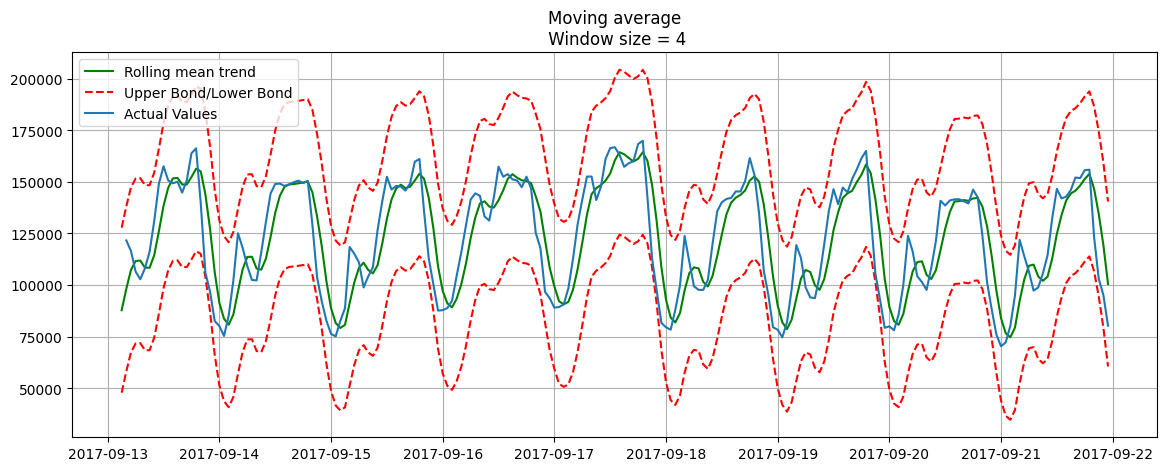

In [113]:
plot_mvng_avg(ads, 4, plot_intervals=True)             #confidence intervals for smoothed vals

Let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe.

In [114]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.22 # say we have 80% drop of ads 

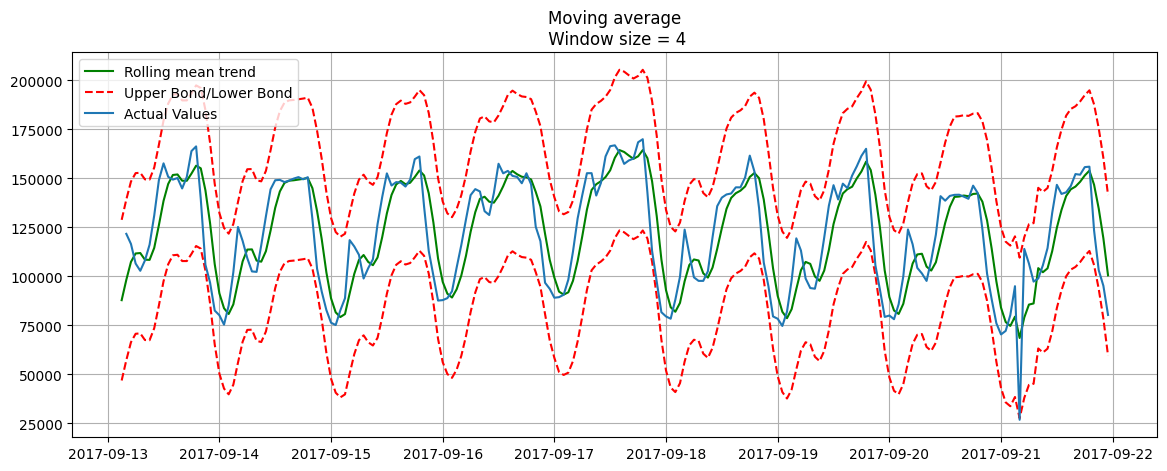

In [115]:
plot_mvng_avg(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

In [116]:
plot_mvng_avg(curr, 7, plot_intervals=True, plot_anomalies=True)    #weekly smoothing

Here, it did not capture the monthly seasonality in our data and marked almost all 30-day peaks as anomalies. If you want to avoid false positives, it is best to consider more complex models.
Weighted average is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.


In [117]:
def wtd_avg(series, wts):
    res = 0
    for n in range(len(wts)):
        res += series.iloc[-n-1] * wts[n]
    return float(res)

In [118]:
wtd_avg(ads, [0.6, 0.3, 0.1])

87025.5

## Exponential smoothing:
Instead of weighting the last k values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:
y^t=α⋅yt+(1−α)⋅y^t−1
 
Here the model value is a weighted average between the current true value and the previous model values. The α weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller α is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by  (1−α) each time, which already contains a multiplication by  (1−α) of previous model values.

In [119]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    res = [series[0]]       #1st val is same as series

    for n in range(1, len(series)):
        res.append(alpha * series[n] + (1 - alpha) * res[n-1])
    return res

In [120]:
def plt_exp_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('classic'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

In [121]:
plt_exp_smoothing(ads.Ads, [0.3, 0.2])

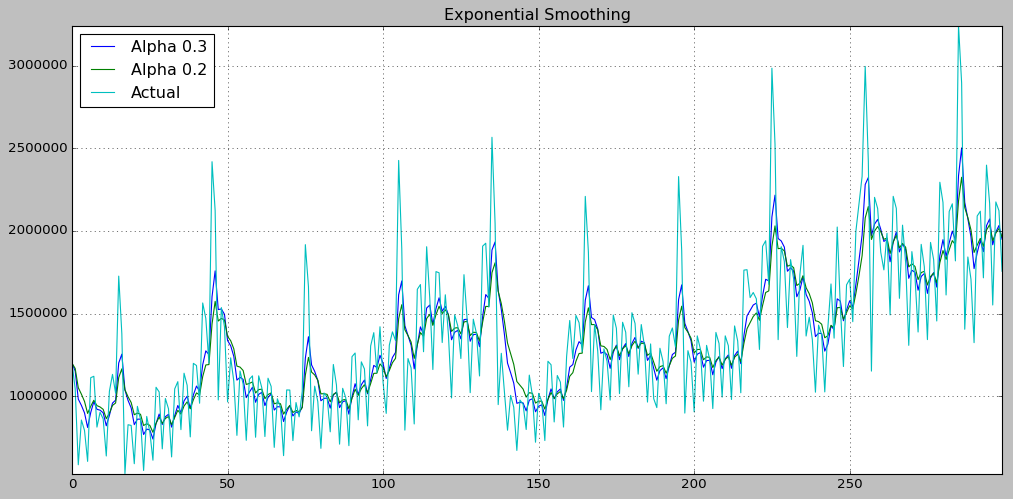

In [122]:
plt_exp_smoothing(curr.GEMS_GEMS_SPENT, [0.3, 0.2])

## Double exponential aka Holt's trend:
Series decomposition will help us -- we obtain two components: intercept (i.e. level) ℓ and slope (i.e. trend) b. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

ℓx=αyx+(1−α)(ℓx−1+bx−1)

bx=β(ℓx−ℓx−1)+(1−β)bx−1

y^x+1=ℓx+bx
 
The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the β coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [123]:
def dbl_exp_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    res = [series[0]]       #1st val is same as series
    for n in range(1, len(series) + 1):
        if n == 1:
            lev, trnd = series[0], series[1] - series[0]
        if n >= len(series):    #forecasting
            val = res[-1]
        else:
            val = series[n]
        last_lev, lev = lev, alpha * val + (1- alpha) * (lev + trnd)
        trnd = beta * (lev - last_lev) + (1 - beta) * trnd
        res.append(lev + trnd)
    return res

def plt_dbl_exp_smoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    with plt.style.context('classic'):
        plt.figure(figsize=(20, 8))
        for a in alphas:
            for b in betas:
                plt.plot(dbl_exp_smoothing(series, a, b), label="Alpha {}, Beta {}".format(a, b))
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

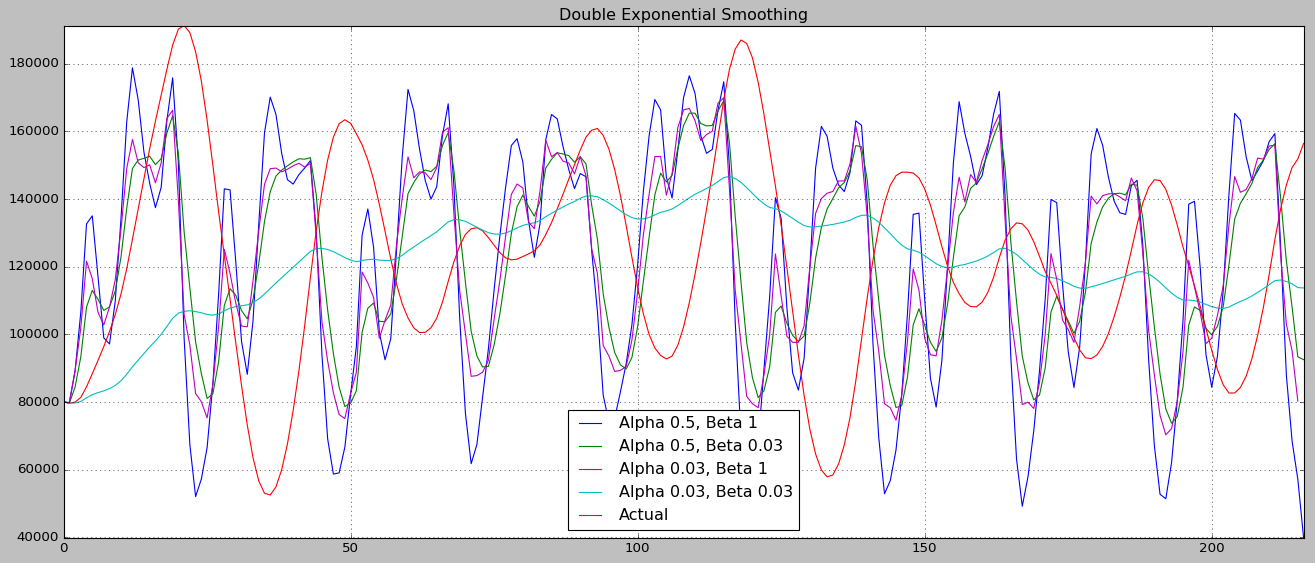

In [124]:
plt_dbl_exp_smoothing(ads.Ads, alphas=[0.5, 0.03], betas=[1, 0.03])

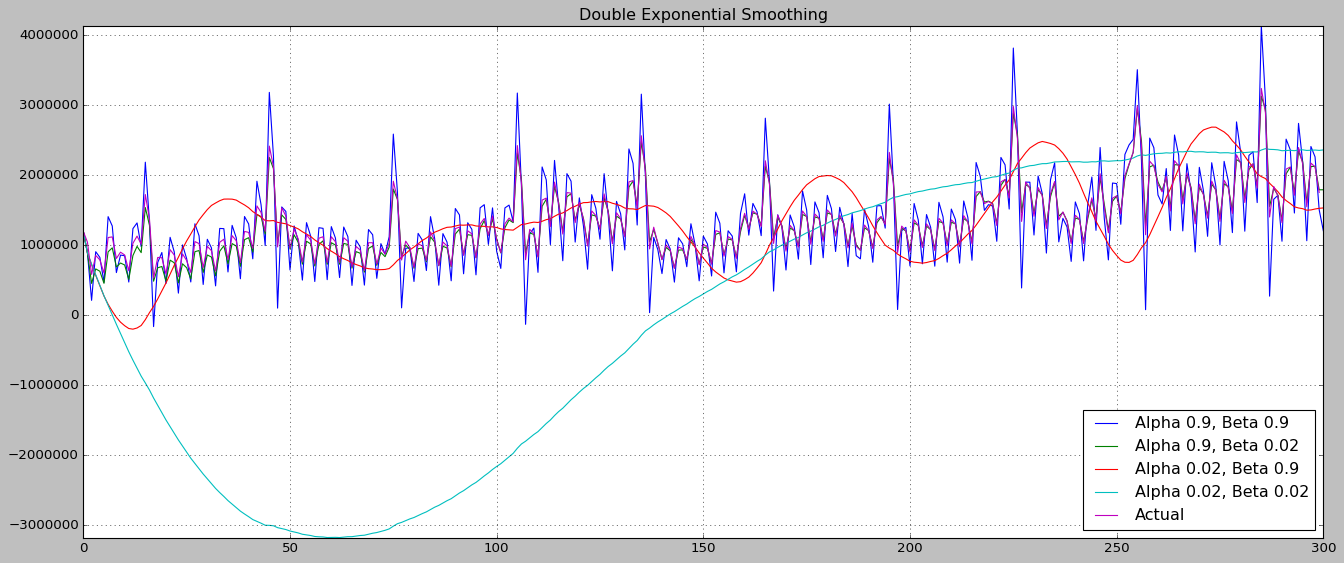

In [125]:
plt_dbl_exp_smoothing(curr.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Now we have to tune two parameters: α and β. The former is responsible for the series smoothing around the trend, the latter for the smoothing of the trend itself. The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be. Certain combinations of the parameters may produce strange results, especially if set manually.

## Triple exponential smoothing aka Holt-Winters:
The idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

The class HoltWinters is a Holt-Winters model with anomaly detection. It initializes the series, parameters, and seasonal length. Calculates initial trend and seasonal components. Applies triple exponential smoothing to forecast the series and detect anomalies, updating the model components iteratively.

In [126]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):         
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor        #scaling factor for the confidence interval in anomaly detection/essentially determines how sensitive your anomaly detection is
        
        
    def initial_trend(self):                        # calculates the initial trend of the series. It averages the difference between corresponding points in consecutive seasons
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}                      #Calculates the initial seasonal values by averaging deviations from the seasonal averages
        season_averages = []                #Computes the average of each season
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])



## Time series cross-validation:
The function performs time series cross-validation to evaluate the Holt-Winters model.
It initializes the model with given parameters (alpha, beta, gamma) and seasonal length (slen).
It uses TimeSeriesSplit to create train-test splits, preserving the time order.
For each split, the model is trained and tested, and the prediction error is computed and stored.
Finally, the function returns the average error across all splits, providing a measure of the model's accuracy

In [127]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                           alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

## Truncated Newton conjugate gradient:
In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters

In [128]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]           #These parameters control the level, trend, and seasonality in the Holt-Winters model, respectively

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x,         #x0=x provides the initial guesses.
               args=(data, mean_squared_log_error),         #passes the time series data and the loss function mean_squared_log_error to the optimization function
               method="TNC",            #specifies the optimization algorithm to use (Truncated Newton Conjugate-Gradient)
               bounds = ((0, 1), (0, 1), (0, 1)))

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, alpha = alpha_final, 
                    beta = beta_final, gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11676236693712227 0.0026881337430822994 0.055312622299154346
CPU times: total: 484 ms
Wall time: 1.17 s


In [129]:
from sklearn.metrics import mean_absolute_percentage_error


def plot_hw(series, plot_intervals=False, plot_anos=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anos - show anomalies 
    """
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean absolute percentage error: {0:.2f}".format(error))

    if plot_anos:
        anos = np.array([np.NAN] * len(series))
        anos[series.values < model.LowerBond[:len(series)]] = series.values[series.values < model.LowerBond]
        anos[series.values > model.UpperBond[:len(series)]] = series.values[series.values > model.UpperBond]
        plt.plot(anos, "o", markersize=10, label="Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0, len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.2, color="grey")
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles="dashed")
    plt.axvspan(len(series) - 20, len(model.result), alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)

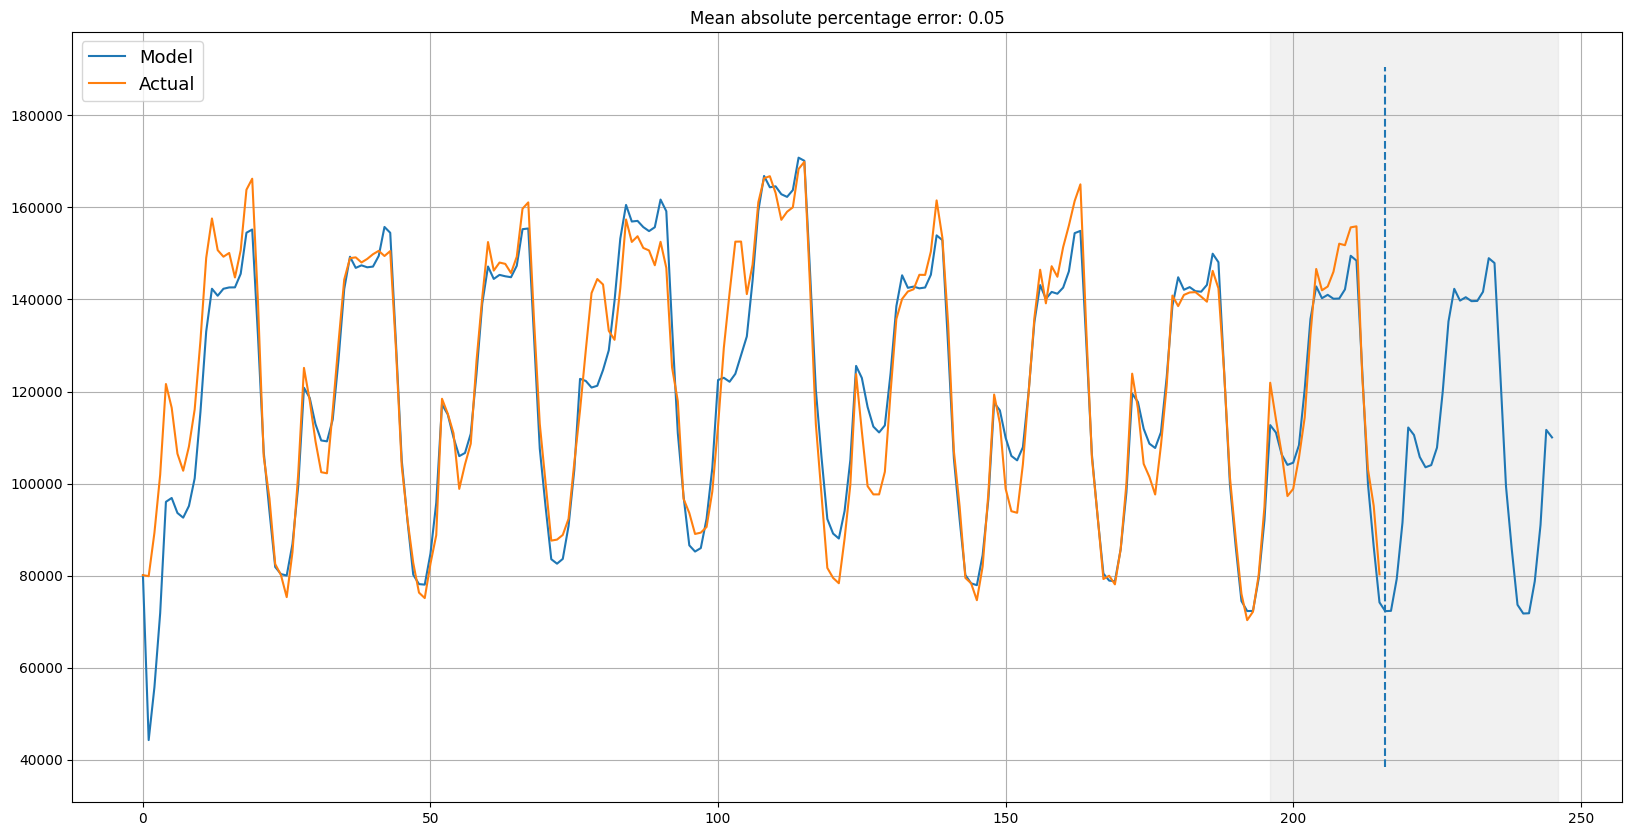

In [130]:
plot_hw(ads.Ads)

Text(0.5, 1.0, "Brutlag's predicted deviation")

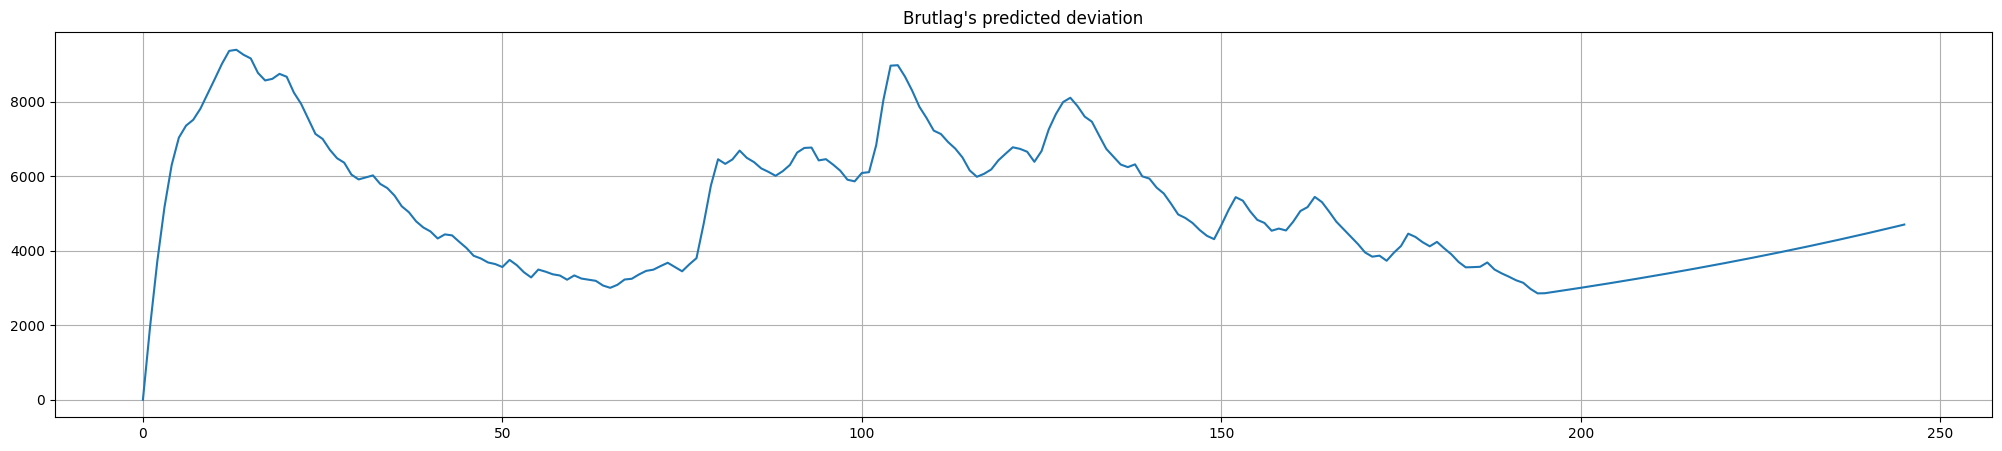

In [132]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")

In [135]:
%%time
data = curr.GEMS_GEMS_SPENT[:-50]
slen = 30       #30-day seasonality

x = [0, 0, 0]

opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_absolute_percentage_error, slen), method="TNC", bounds=((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen=slen, alpha=alpha_final, beta=beta_final, gamma=gamma_final, n_preds=100, scaling_factor=3)

model.triple_exponential_smoothing()

0.013270254679429161 0.04689448914982469 0.0
CPU times: total: 1.5 s
Wall time: 2.38 s


In [136]:
plot_hw(curr.GEMS_GEMS_SPENT)